In [1]:
!pip install lightning --quiet

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import lightning as L
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


2024-05-04 10:17:07.551914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 10:17:07.552056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 10:17:07.834613: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
batch_size = 64
img_size = 64
img_chnl = 1
z_dim = 100
num_epochs = 5
features_disc = 64
features_gen = 64
critic_iters = 5
weight_clip = 0.01
lambda_gp = 10

In [4]:
transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(img_chnl)],
        [0.5 for _ in range(img_chnl)],
    )
])

In [5]:
dataset = datasets.MNIST(root = "./", train = True, transform = transforms, download = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 33561711.52it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1138311.49it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10417005.16it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2246524.62it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers=4)

In [7]:
def gradient_penalty(critic, real, fake, device = "cpu"):
    batch_size, c, h, w = real.shape
    epsilon = torch.rand((batch_size,1,1,1)).repeat(1,c,h,w).to(device)
    epsilon = torch.rand((batch_size,1,1,1)).to(device)
    

    interpolated_imgs = real * epsilon + fake * (1-epsilon)
    mixed_scores = critic(interpolated_imgs)
    
    gradient = torch.autograd.grad(
        inputs = interpolated_imgs,
        outputs = mixed_scores,
        grad_outputs = torch.ones_like(mixed_scores),
        create_graph = True,
        retain_graph = True
    )
    gradient = gradient[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim  = 1)
    gradient_penalty = torch.mean((gradient_norm -1)**2)
    return gradient_penalty


In [8]:
fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

In [9]:
class Discriminator(L.LightningModule):
    def __init__(self, img_channels, features_dim):
        super(Discriminator, self).__init__()
    
        self.critic = nn.Sequential(
            nn.Conv2d(img_channels, features_dim, kernel_size=4, stride=2, padding=1),
            self._conv_layer(features_dim, features_dim * 2, 4, 2, 1),
            self._conv_layer(features_dim * 2, features_dim * 4, 4, 2, 1),
            self._conv_layer(features_dim * 4, features_dim * 8, 4, 2, 1),
            nn.Conv2d(features_dim * 8, 1, kernel_size=4, stride=2, padding=0),
        )    
    
    def forward(self, x):
        return self.critic(x)
    
    def configure_optimizers(self):
        opt_critic = optim.Adam(self.parameters(), lr = lr, betas=(0, 0.9))
        return opt_critic
    
    def _conv_layer(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias = False
            ),
            nn.InstanceNorm2d(out_channels, affine = True),
            nn.LeakyReLU(0.25),
        )

In [10]:
class Generator(L.LightningModule):
    def __init__(self, channels_noise, img_channels, features_gen):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._convTp_layer(channels_noise, features_gen*16, 4, 1, 0),
            self._convTp_layer(features_gen*16, features_gen * 8, 4, 2, 1),
            self._convTp_layer(features_gen * 8, features_gen*4, 4, 2, 1),
            self._convTp_layer(features_gen*4, features_gen*2, 4, 2, 1),
            nn.ConvTranspose2d(features_gen * 2, img_channels, 4, 2, 1),
            nn.Tanh(),
        )
        
    
    def _convTp_layer(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels,
                kernel_size,
                stride, padding,
                bias = False,
            ),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)
    
    def configure_optimizers(self):
        opt_gen = optim.Adam(self.parameters(), lr = lr,betas = (0, 0.9))
        return opt_gen

In [11]:
gen = Generator(z_dim, img_chnl, features_gen).to(device)
gen = nn.DataParallel(gen)
critic = Discriminator(img_chnl, features_disc).to(device)
critic = nn.DataParallel(critic)

In [12]:
opt_gen = optim.Adam(gen.parameters(), lr = lr,betas = (0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr = lr, betas=(0, 0.9))

0
Epoch [0/5] Batch 100/938                   Loss D: -23.1799, loss G: -3.8386
tensor([[[[0.8046]]]], device='cuda:0')


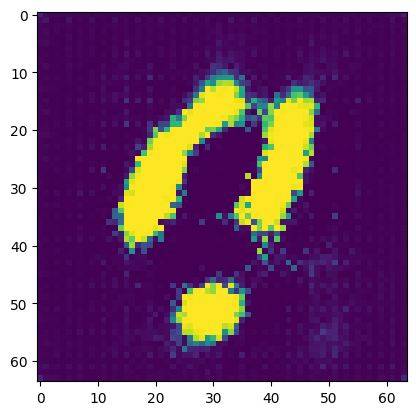

Epoch [0/5] Batch 200/938                   Loss D: -18.5358, loss G: -0.3704
tensor([[[[13.7333]]]], device='cuda:0')


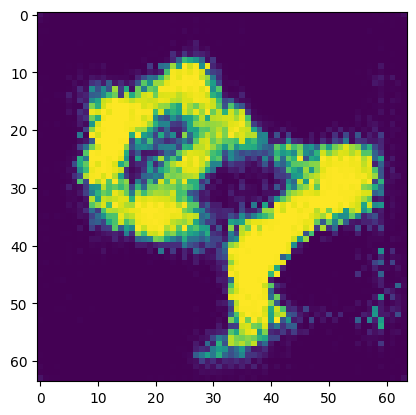

Epoch [0/5] Batch 300/938                   Loss D: -17.0442, loss G: 3.5635
tensor([[[[14.0353]]]], device='cuda:0')


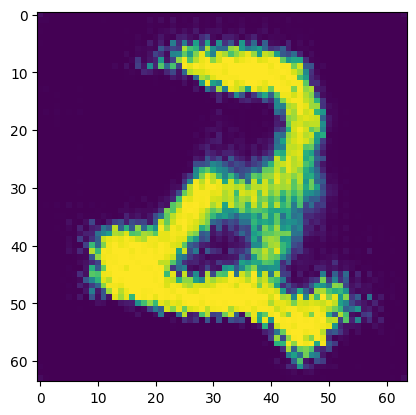

Epoch [0/5] Batch 400/938                   Loss D: -13.3282, loss G: -1.8651
tensor([[[[8.4775]]]], device='cuda:0')


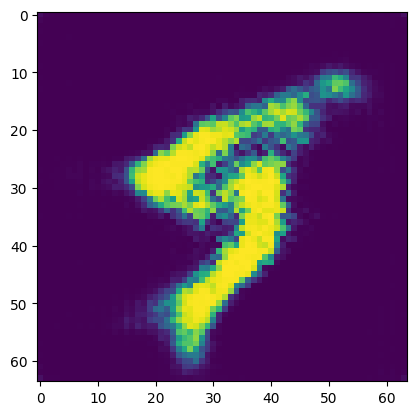

Epoch [0/5] Batch 500/938                   Loss D: -12.1188, loss G: -0.5542
tensor([[[[9.8031]]]], device='cuda:0')


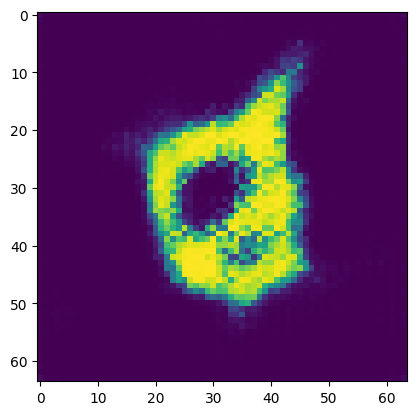

Epoch [0/5] Batch 600/938                   Loss D: -10.9867, loss G: 3.2403
tensor([[[[-4.4808]]]], device='cuda:0')


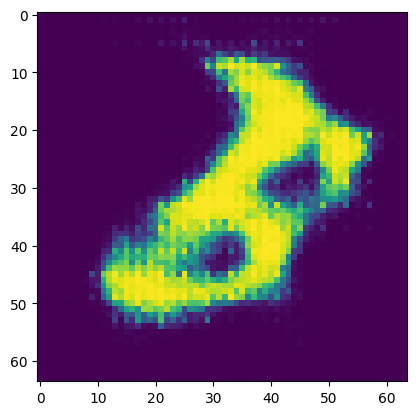

Epoch [0/5] Batch 700/938                   Loss D: -17.2362, loss G: 7.1148
tensor([[[[13.1700]]]], device='cuda:0')


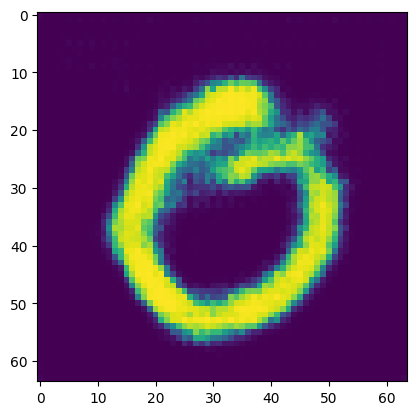

Epoch [0/5] Batch 800/938                   Loss D: -10.0396, loss G: 11.6246
tensor([[[[-9.1195]]]], device='cuda:0')


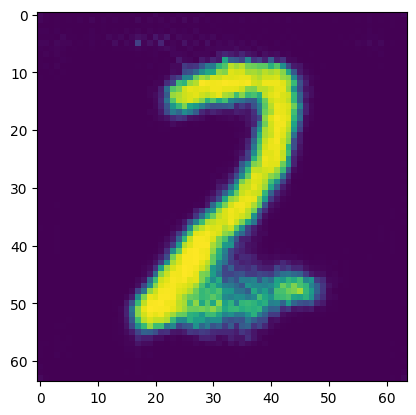

Epoch [0/5] Batch 900/938                   Loss D: -10.6008, loss G: 10.6861
tensor([[[[2.2214]]]], device='cuda:0')


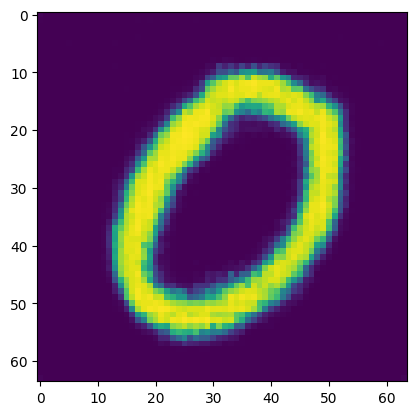

Epoch [1/5] Batch 100/938                   Loss D: -8.3353, loss G: 13.5208
tensor([[[[-11.6488]]]], device='cuda:0')


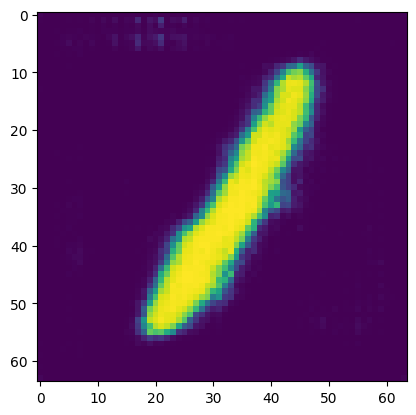

Epoch [1/5] Batch 200/938                   Loss D: -10.5507, loss G: 7.8032
tensor([[[[11.8125]]]], device='cuda:0')


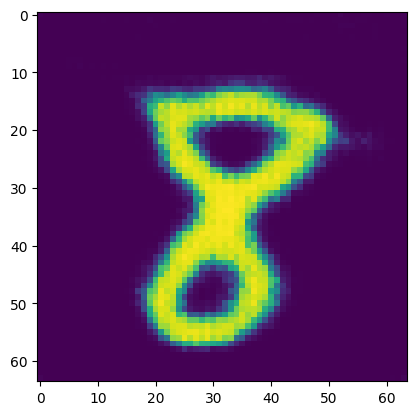

Epoch [1/5] Batch 300/938                   Loss D: -9.6348, loss G: 4.5711
tensor([[[[1.7472]]]], device='cuda:0')


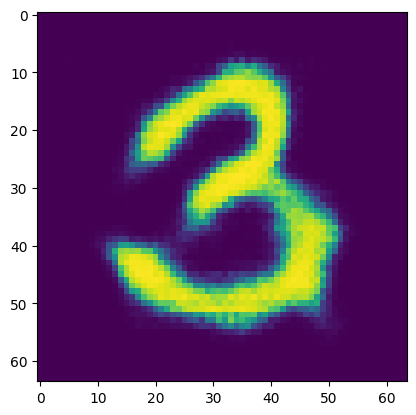

Epoch [1/5] Batch 400/938                   Loss D: -9.4129, loss G: 6.6182
tensor([[[[2.1923]]]], device='cuda:0')


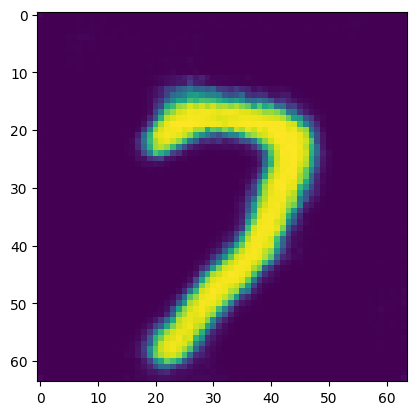

Epoch [1/5] Batch 500/938                   Loss D: -11.1288, loss G: 10.1737
tensor([[[[-1.6122]]]], device='cuda:0')


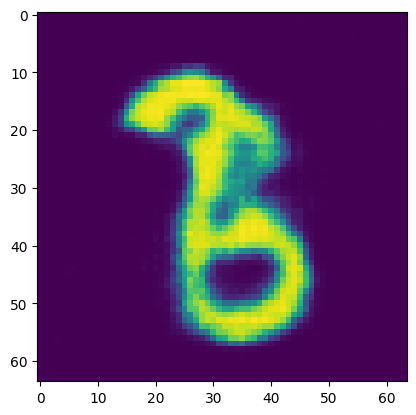

Epoch [1/5] Batch 600/938                   Loss D: -9.4897, loss G: 9.0409
tensor([[[[-4.3176]]]], device='cuda:0')


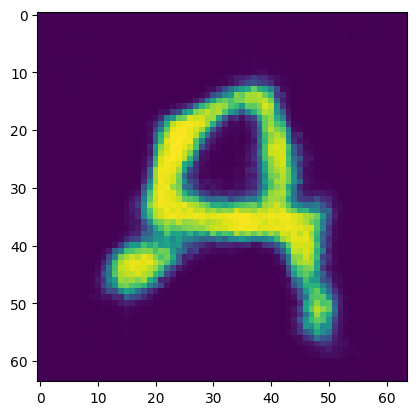

Epoch [1/5] Batch 700/938                   Loss D: -10.2527, loss G: 11.7179
tensor([[[[-18.1692]]]], device='cuda:0')


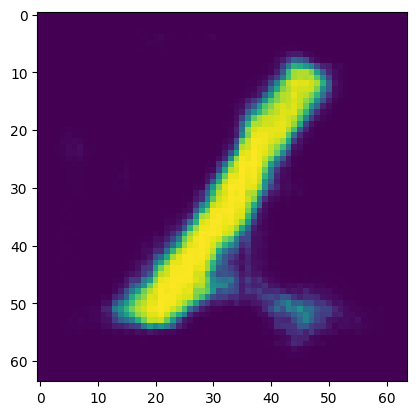

Epoch [1/5] Batch 800/938                   Loss D: -8.4636, loss G: 8.7355
tensor([[[[5.6774]]]], device='cuda:0')


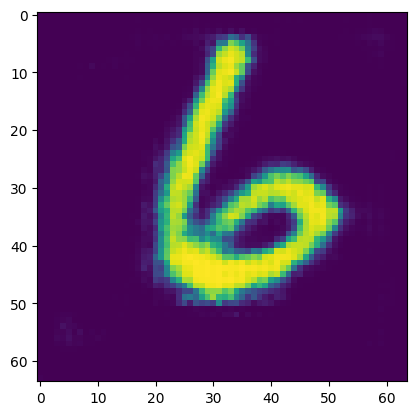

Epoch [1/5] Batch 900/938                   Loss D: -6.7143, loss G: 11.0752
tensor([[[[-24.5083]]]], device='cuda:0')


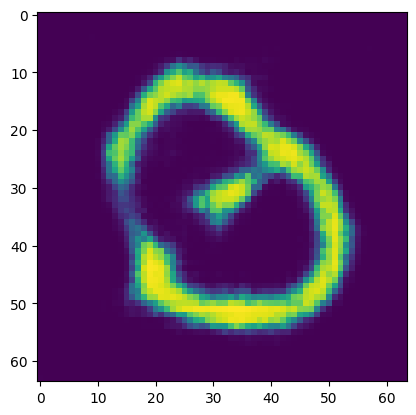

2
Epoch [2/5] Batch 100/938                   Loss D: -10.4210, loss G: 7.7750
tensor([[[[14.2460]]]], device='cuda:0')


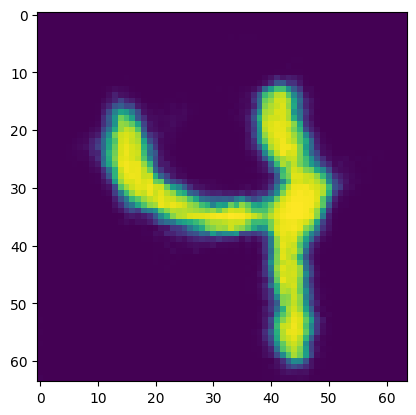

Epoch [2/5] Batch 200/938                   Loss D: -10.2264, loss G: 15.6522
tensor([[[[-4.4165]]]], device='cuda:0')


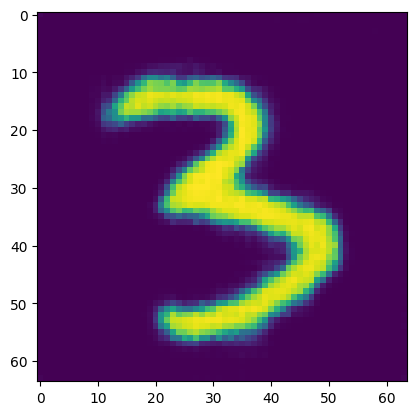

Epoch [2/5] Batch 300/938                   Loss D: -8.2863, loss G: 9.9913
tensor([[[[-9.2315]]]], device='cuda:0')


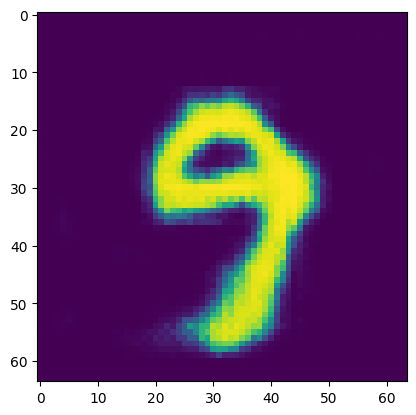

Epoch [2/5] Batch 400/938                   Loss D: -7.9364, loss G: 12.9454
tensor([[[[-13.2984]]]], device='cuda:0')


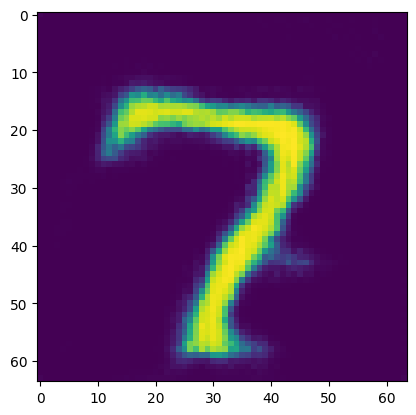

Epoch [2/5] Batch 500/938                   Loss D: -7.2234, loss G: 11.4335
tensor([[[[-10.4636]]]], device='cuda:0')


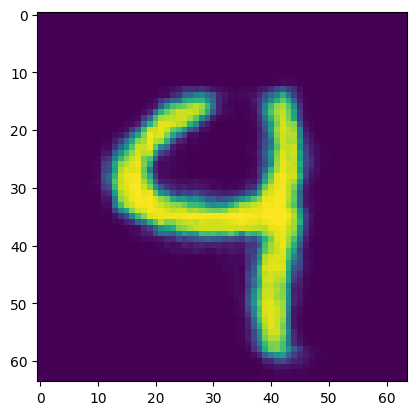

Epoch [2/5] Batch 600/938                   Loss D: -9.3512, loss G: 13.4868
tensor([[[[-14.3466]]]], device='cuda:0')


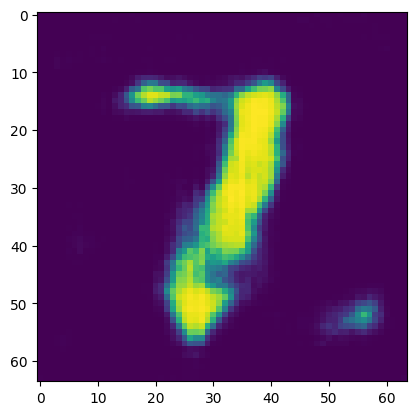

Epoch [2/5] Batch 700/938                   Loss D: -9.5019, loss G: 16.9832
tensor([[[[-5.9746]]]], device='cuda:0')


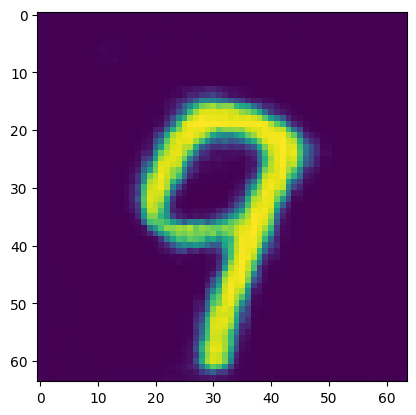

Epoch [2/5] Batch 800/938                   Loss D: -10.6219, loss G: 9.3492
tensor([[[[-8.6912]]]], device='cuda:0')


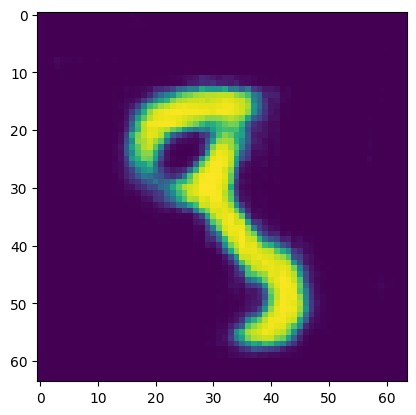

Epoch [2/5] Batch 900/938                   Loss D: -9.3839, loss G: 9.4112
tensor([[[[-25.7895]]]], device='cuda:0')


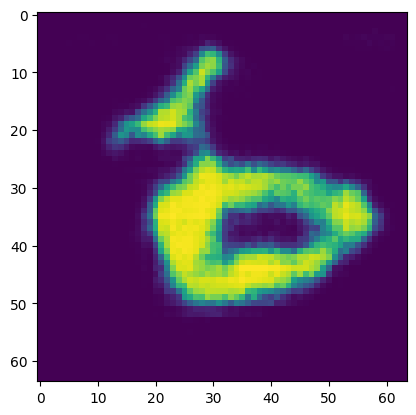

Epoch [3/5] Batch 100/938                   Loss D: -8.9269, loss G: 8.4782
tensor([[[[-21.8098]]]], device='cuda:0')


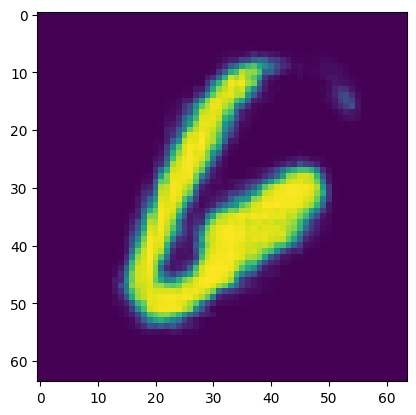

Epoch [3/5] Batch 200/938                   Loss D: -7.3047, loss G: 6.3471
tensor([[[[0.5256]]]], device='cuda:0')


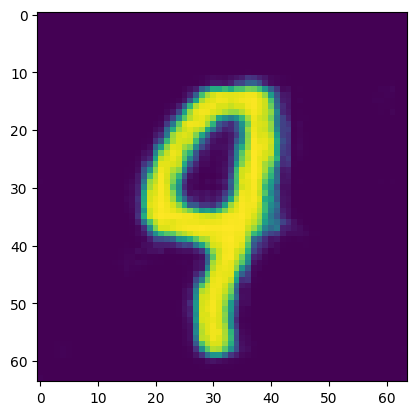

Epoch [3/5] Batch 300/938                   Loss D: -7.9564, loss G: 6.6177
tensor([[[[-4.2908]]]], device='cuda:0')


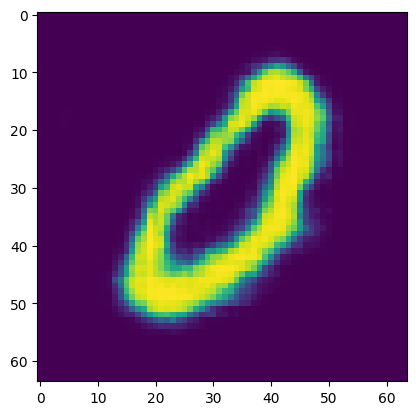

Epoch [3/5] Batch 400/938                   Loss D: -6.8173, loss G: 13.2049
tensor([[[[-15.7788]]]], device='cuda:0')


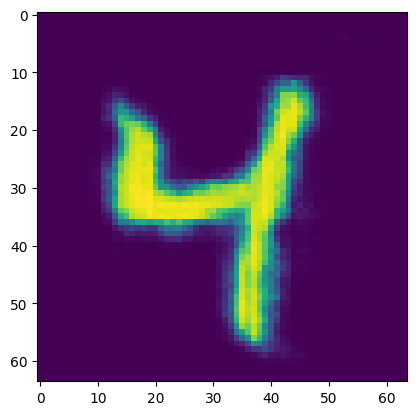

Epoch [3/5] Batch 500/938                   Loss D: -6.4735, loss G: 9.7691
tensor([[[[-1.9778]]]], device='cuda:0')


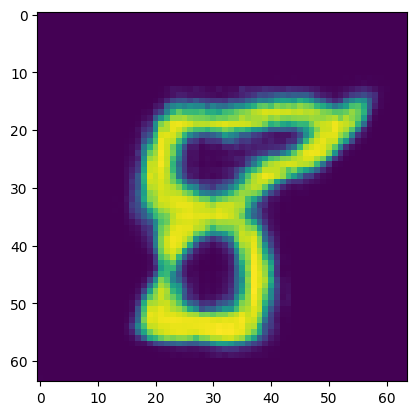

Epoch [3/5] Batch 600/938                   Loss D: -8.9410, loss G: 8.6187
tensor([[[[0.3227]]]], device='cuda:0')


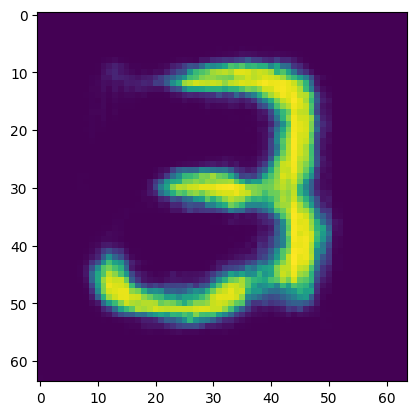

Epoch [3/5] Batch 700/938                   Loss D: -8.0334, loss G: 10.8163
tensor([[[[-4.2389]]]], device='cuda:0')


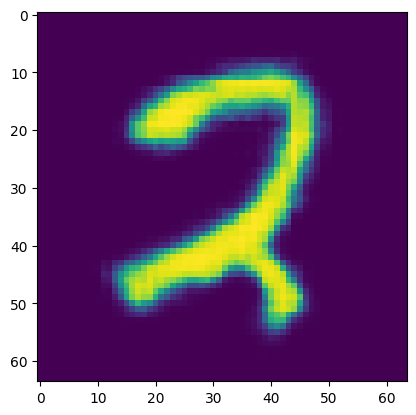

Epoch [3/5] Batch 800/938                   Loss D: -6.6190, loss G: 15.0823
tensor([[[[-11.4457]]]], device='cuda:0')


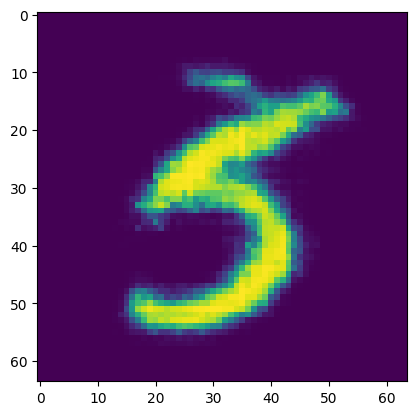

Epoch [3/5] Batch 900/938                   Loss D: -6.3577, loss G: 11.6722
tensor([[[[-13.8459]]]], device='cuda:0')


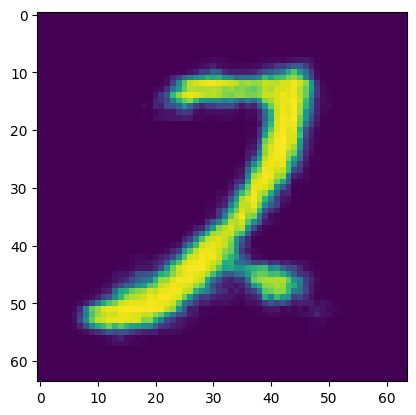

4
Epoch [4/5] Batch 100/938                   Loss D: -6.7916, loss G: 7.1390
tensor([[[[-16.9090]]]], device='cuda:0')


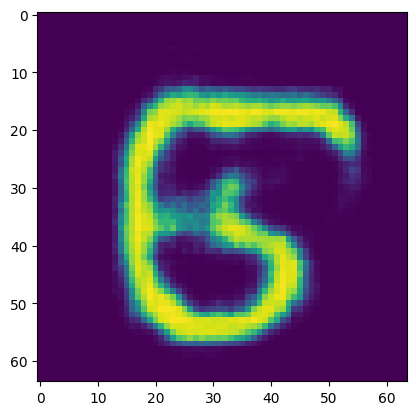

Epoch [4/5] Batch 200/938                   Loss D: -7.3950, loss G: 13.0752
tensor([[[[-6.4623]]]], device='cuda:0')


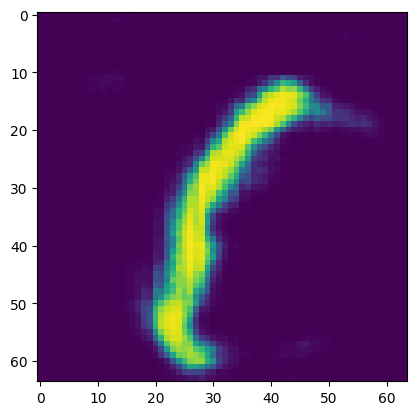

Epoch [4/5] Batch 300/938                   Loss D: -8.0046, loss G: 11.3184
tensor([[[[-7.2534]]]], device='cuda:0')


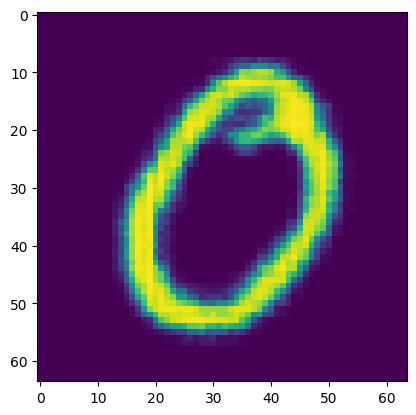

Epoch [4/5] Batch 400/938                   Loss D: -6.9332, loss G: 12.6888
tensor([[[[-17.5393]]]], device='cuda:0')


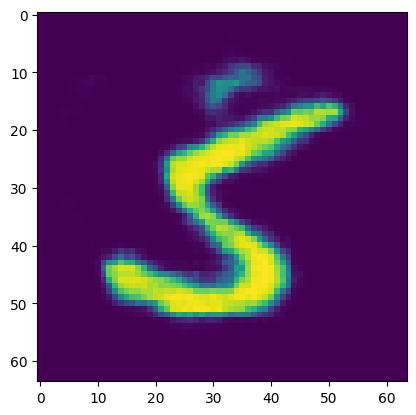

Epoch [4/5] Batch 500/938                   Loss D: -6.9216, loss G: 11.9440
tensor([[[[-5.8124]]]], device='cuda:0')


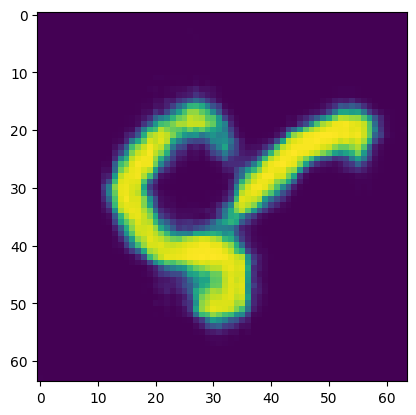

Epoch [4/5] Batch 600/938                   Loss D: -8.4360, loss G: 10.7223
tensor([[[[-9.3069]]]], device='cuda:0')


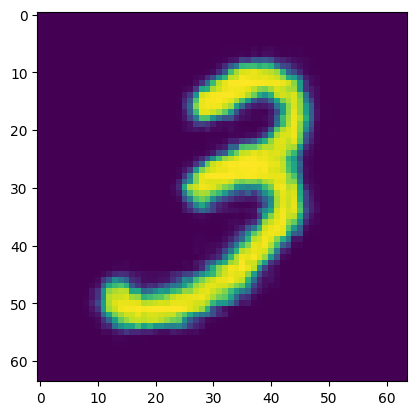

Epoch [4/5] Batch 700/938                   Loss D: -7.8400, loss G: 16.3538
tensor([[[[-12.2848]]]], device='cuda:0')


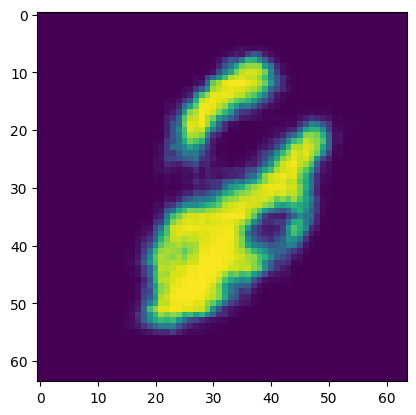

Epoch [4/5] Batch 800/938                   Loss D: -7.7083, loss G: 12.6830
tensor([[[[-17.3709]]]], device='cuda:0')


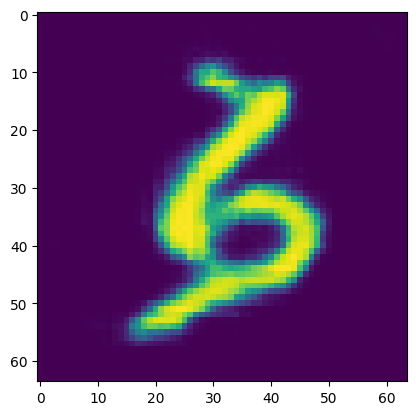

Epoch [4/5] Batch 900/938                   Loss D: -6.5893, loss G: 8.2349
tensor([[[[-13.3766]]]], device='cuda:0')


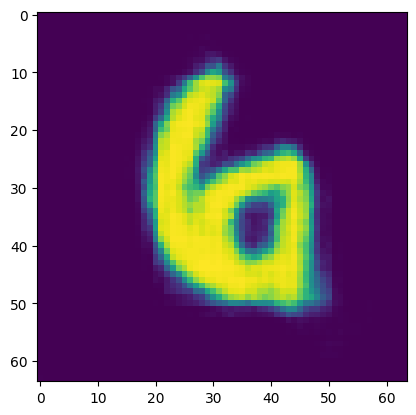

In [13]:
for epoch in range(num_epochs):
    if (epoch%2 == 0):
        print(epoch)
    for batch_idx, (real, _) in enumerate(data_loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        # maximize E[critic(real)] - E[critic(fake)]
        for _ in range(critic_iters):
            noise = torch.randn(cur_batch_size, z_dim, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device)
            loss_critic = (lambda_gp * gp) - (torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph = True)
            opt_critic.step()
            
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        if (batch_idx % 100 == 0 and batch_idx > 0):
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(data_loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )
            
            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
                step += 1
                
                noise = torch.randn(1, z_dim, 1, 1).to(device)
                generated_image = gen(noise)
                pred = critic(generated_image)
                print(pred)
                plt.imshow(generated_image[0][0].detach().cpu())
                plt.show()


In [14]:
print("Done.")

Done.
